In [172]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import string
import datetime
import tensorflow as tf



In [173]:
dataset_ini = pd.read_csv("dataset/dataset_elpino_codigos.csv", delimiter=';')
#print(dataset.head())

In [174]:
# Filtrar las clases que tienen al menos 2 ejemplos
class_counts = dataset_ini['GRD_Codigo'].value_counts()
valid_classes = class_counts[class_counts > 1].index
dataset = dataset_ini[dataset_ini['GRD_Codigo'].isin(valid_classes)]
#print(dataset_filtered)

In [175]:

# Seleccionar las columnas 
diag_cols  = [col for col in dataset.columns if col.startswith('Diag_Cod')]
proc_cols = [col for col in dataset.columns if col.startswith('Proc_Cod')]
other_cols = ['Edad', 'Sexo_Cod']

# Concatenar todos los diagnósticos de cada paciente en una lista
diag_proc_text = dataset[diag_cols + proc_cols].fillna('').astype(str).apply(lambda x: ' '.join(x), axis=1)

print(diag_proc_text[0])

A41.8 B37.6 I39.8 N10 B96.1 L89.9 L08.9 B96.2 A41.5 J86.9 U07.1 Y95 N18.5 E87.1 D64.9 G82.2 N31.9 I10 K70.4 F19.2 F10.2 E46 G40.9 L21.9 Z93.5 Z93.3 Z99.2 Z91.6        86.28 34.91 88.38 87.41 88.75 88.01 88.43 88.41 87.44 99.29 99.19 99.18 99.21 99.26 99.23 93.94 89.52 90.59 89.65 39.95 39.95 99.04 90.39 99.84 88.72 90.42 90.52 91.39 91.33 87.03


In [176]:
# Inicializar el Tokenizer y ajustarlo a los diagnósticos
tokenizer =  Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(diag_proc_text)
diagnosticos_sequences = tokenizer.texts_to_sequences(diag_proc_text)
words=list(tokenizer.word_index.keys())
vocabulary=len(words)+1
print(tokenizer.word_index)
print(vocabulary)

{'90.59': 1, '89.7': 2, '90.39': 3, '99.29': 4, '99.18': 5, '99.21': 6, '99.19': 7, '89.26': 8, '93.82': 9, 'i10': 10, '57.94': 11, '93.96': 12, '91.39': 13, '93.01': 14, '89.66': 15, '93.18': 16, '87.44': 17, ...
4536


In [177]:
# Para hacer que todas las secuencias tengan la misma longitud
max_length = max([len(seq) for seq in diagnosticos_sequences])  # Longitud máxima de secuencias
X = pad_sequences(diagnosticos_sequences, maxlen=max_length, padding='post')

print(X[0])
print(len(X[0]))

[ 487 2413 2066  152  225  263 1220   99  910  911   71  161  151  101
   68  670  746   10  224  357   97  217  176 1221  944  546  238  418
  213  428   53   32  122   29   78  128   17    4    7    5    6   37
   50   31   35    1   33  196  196   69    3   18   66  126   51   13
   82   40    0    0    0    0    0    0    0]
65


In [178]:
# Se transforma la variable de sexo a entero y se genera variable con el valor de edad y sexo.

dataset.loc[:, 'Sexo_Cod'] = dataset['Sexo_Cod'].map({'H': 0, 'M': 1})
dataset.loc[:, 'Edad'] = dataset['Edad']
X_edad_sexo = dataset[['Edad', 'Sexo_Cod']].values.astype('int32')
print(X_edad_sexo.dtype)
print(X_edad_sexo[5])

int32
[49  1]


In [179]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(dataset['GRD_Codigo'])

In [180]:
# Divide el data set en conjunto de entrenamiento y prueba

x_train_diag_proc, x_val_diag_proc, x_train_edad_sexo, x_val_edad_sexo, y_train, y_val = train_test_split(X, X_edad_sexo, Y, test_size=0.2, stratify=Y, random_state=12122008)


In [181]:
# Definir el modelo
input_diag_proc = Input(shape=(X.shape[1],), name='diag_proc_input')
input_edad_sexo = Input(shape=(2,), name='edad_sexo_input')

In [182]:
# formato funcional no puede tener multiples entradas
#model = Sequential()
#model.add(Embedding(input_dim=vocabulary,output_dim=64))
#model.add(GRU(16))
#model.add(Dense(1, activation='softmax'))
#model.summary()

# Embedding para los diagnósticos y procedimientos
embedding_layer = Embedding(input_dim=vocabulary, output_dim=128)(input_diag_proc)
# Capa GRU
gru_layer = GRU(128)(embedding_layer)

# Concatenar GRU con Edad y Sexo
concat_layer = Concatenate()([gru_layer, input_edad_sexo])

# Capa conectada y salida
dense_layer = Dense(128, activation='relu')(concat_layer) 
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_layer)

In [183]:

# define el modelo y configura el monitoreo del entrenamiento.

model = Model(inputs=[input_diag_proc, input_edad_sexo], outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

tag="gruemb"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ diag_proc_input     │ (None, 65)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 65, 128)   │    580,608 │ diag_proc_input[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 128)       │     99,072 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edad_sexo_input     │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 130)       │          0 │ gru_4[0][0],      │
│ (Concatenate)       │                   │            │ edad_sexo_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     16,768 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 189)       │     24,381 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 720,829 (2.75 MB)

 Trainable params: 720,829 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

In [184]:
# Entrenamiento
nn = model.fit([x_train_diag_proc, x_train_edad_sexo], y_train, validation_data=({'diag_proc_input': x_val_diag_proc, 'edad_sexo_input': x_val_edad_sexo}, y_val), epochs=9, batch_size=4, validation_split=0.2,verbose=2, callbacks=[tensorboard_callback])
model.save('model_{0}.keras'.format(tag))

Epoch 1/9


C:\Users\aris_\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['diag_proc_input', 'edad_sexo_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\aris_\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['diag_proc_input', 'edad_sexo_input']. Received: the structure of inputs={'diag_proc_input': '*', 'edad_sexo_input': '*'}
  warnings.warn(


2908/2908 - 33s - 11ms/step - accuracy: 0.3189 - loss: 3.0633 - val_accuracy: 0.5113 - val_loss: 2.1441
Epoch 2/9
2908/2908 - 35s - 12ms/step - accuracy: 0.6342 - loss: 1.5817 - val_accuracy: 0.7077 - val_loss: 1.2772
Epoch 3/9
2908/2908 - 32s - 11ms/step - accuracy: 0.7956 - loss: 0.8805 - val_accuracy: 0.8160 - val_loss: 0.8997
Epoch 4/9
2908/2908 - 32s - 11ms/step - accuracy: 0.8697 - loss: 0.5261 - val_accuracy: 0.8539 - val_loss: 0.7589
Epoch 5/9
2908/2908 - 31s - 11ms/step - accuracy: 0.9152 - loss: 0.3239 - val_accuracy: 0.8704 - val_loss: 0.7587
Epoch 6/9
2908/2908 - 32s - 11ms/step - accuracy: 0.9354 - loss: 0.2280 - val_accuracy: 0.8848 - val_loss: 0.7984
Epoch 7/9
2908/2908 - 31s - 11ms/step - accuracy: 0.9551 - loss: 0.1504 - val_accuracy: 0.8872 - val_loss: 0.8536
Epoch 8/9
2908/2908 - 32s - 11ms/step - accuracy: 0.9654 - loss: 0.1113 - val_accuracy: 0.8814 - val_loss: 0.9101
Epoch 9/9
2908/2908 - 32s - 11ms/step - accuracy: 0.9732 - loss: 0.0887 - val_accuracy: 0.8979 - v

In [185]:
# Evaluar el modelo
loss, accuracy = model.evaluate([x_val_diag_proc, x_val_edad_sexo], y_val)
print(f'Loss: {loss}, Accuracy: {accuracy}')

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8987 - loss: 0.9920
Loss: 0.9180811643600464, Accuracy: 0.8978679776191711


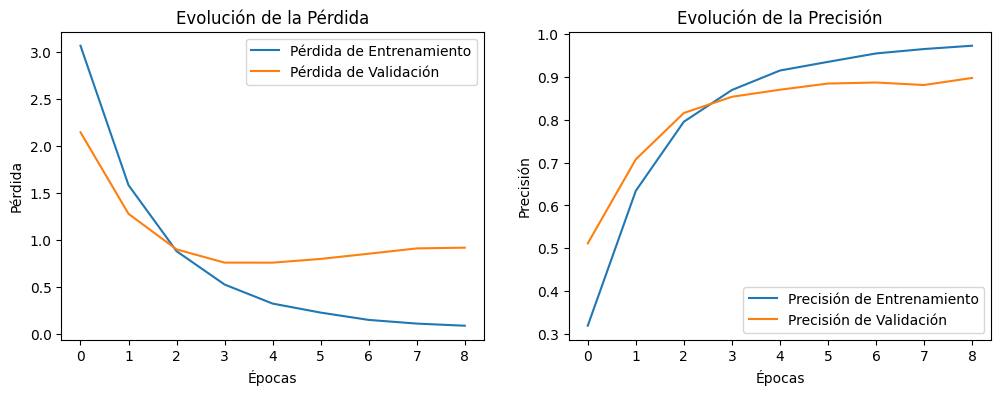

In [186]:
import matplotlib.pyplot as plt

# Graficar la pérdida (loss)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(nn.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(nn.history['val_loss'], label='Pérdida de Validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la precisión (accuracy)
plt.subplot(1, 2, 2)
plt.plot(nn.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(nn.history['val_accuracy'], label='Precisión de Validación')
plt.title('Evolución de la Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()



In [206]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predicción del conjunto de prueba
y_pred = model.predict({'diag_proc_input': x_val_diag_proc, 'edad_sexo_input': x_val_edad_sexo})
y_pred_classes = np.argmax(y_pred, axis=1)

# Filtrar las clases más frecuentes
class_counts = pd.Series(y_val).value_counts().head(10)  # Seleccionar las 10 clases más comunes
most_common_classes = class_counts.index


# Crear una máscara que seleccione las muestras que pertenecen a las clases más comunes
mask_val = np.isin(y_val, most_common_classes)
mask_pred = np.isin(y_pred_classes, most_common_classes)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


1104
1104


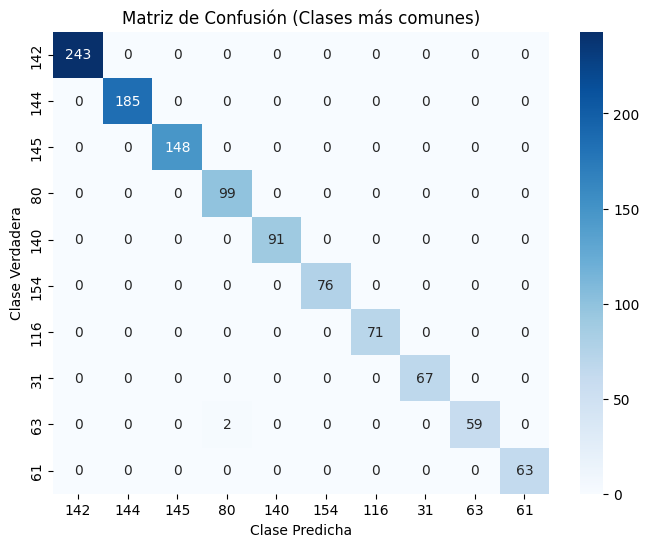

In [207]:

# Aplicar la máscara a ambos (valores verdaderos y predicciones)
filtered_y_val = y_val[mask_val & mask_pred]  # Filtrar sólo las clases más comunes
filtered_y_pred_classes = y_pred_classes[mask_val & mask_pred]  # Filtrar sólo las clases más comunes

#print(len(filtered_y_val))
#print(len(filtered_y_pred_classes))

# Filtrar las filas y columnas de la matriz de confusión para las clases más comunes
filtered_cm = confusion_matrix(filtered_y_val, filtered_y_pred_classes, labels=most_common_classes)

# Graficar la matriz de confusión filtrada
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_cm, annot=True, fmt='d', cmap='Blues', xticklabels=most_common_classes, yticklabels=most_common_classes)
plt.title('Matriz de Confusión (Clases más comunes)')
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

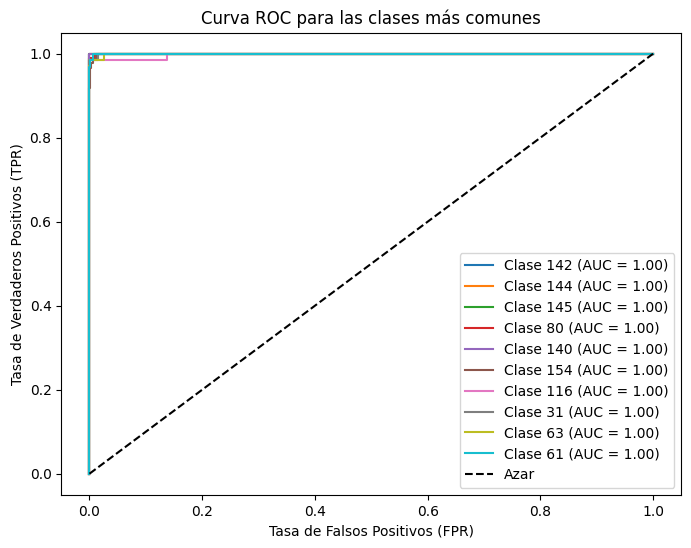

In [208]:

# Filtrar y_val y y_pred
filtered_y_val = y_val[mask_val]
filtered_y_pred = y_pred[mask_val]

# Crear la Curva ROC para cada clase
fpr = {}  # Falsos positivos
tpr = {}  # Verdaderos positivos
roc_auc = {}  # AUC por clase

plt.figure(figsize=(8, 6))

# Calcular la Curva ROC para cada clase
for class_id in most_common_classes:
    # Convertir las etiquetas de la clase actual a formato binario (1 si pertenece a la clase, 0 si no)
    y_val_binary = (filtered_y_val == class_id).astype(int)
    
    # Obtener las probabilidades para la clase actual
    y_pred_prob = filtered_y_pred[:, class_id]
    
    # Calcular FPR, TPR y AUC para la clase actual
    fpr[class_id], tpr[class_id], _ = roc_curve(y_val_binary, y_pred_prob)
    roc_auc[class_id] = auc(fpr[class_id], tpr[class_id])
    
    # Graficar la Curva ROC para la clase actual
    plt.plot(fpr[class_id], tpr[class_id], label=f'Clase {class_id} (AUC = {roc_auc[class_id]:.2f})')

# Gráfica de la línea diagonal de azar
plt.plot([0, 1], [0, 1], 'k--', label='Azar')

plt.title('Curva ROC para las clases más comunes')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()


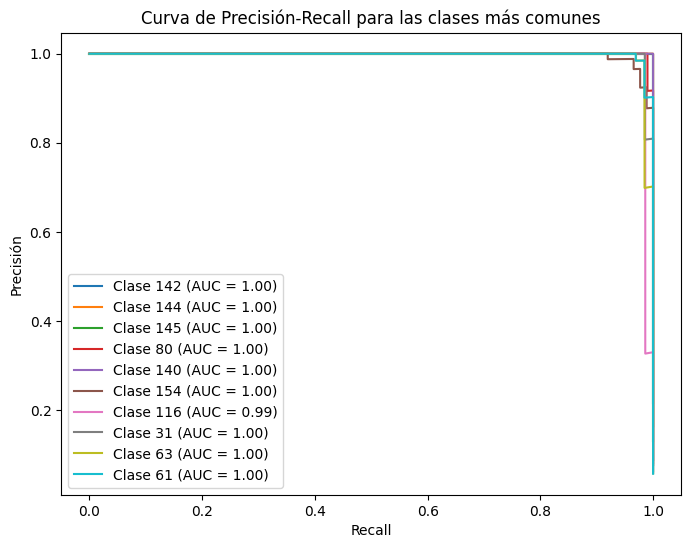

In [209]:

# Crear la Curva de Precisión-Recall para cada clase
precision = {}
recall = {}
pr_auc = {}

plt.figure(figsize=(8, 6))

# Calcular la Curva de Precisión-Recall para cada clase
for class_id in most_common_classes:
    # Convertir las etiquetas de la clase actual a formato binario (1 si pertenece a la clase, 0 si no)
    y_val_binary = (filtered_y_val == class_id).astype(int)
    
    # Obtener las probabilidades para la clase actual
    y_pred_prob = filtered_y_pred[:, class_id]
    
    # Calcular Precision, Recall y AUC para la clase actual
    precision[class_id], recall[class_id], _ = precision_recall_curve(y_val_binary, y_pred_prob)
    pr_auc[class_id] = auc(recall[class_id], precision[class_id])
    
    # Graficar la Curva de Precisión-Recall para la clase actual
    plt.plot(recall[class_id], precision[class_id], label=f'Clase {class_id} (AUC = {pr_auc[class_id]:.2f})')

# Gráfica de la línea diagonal
plt.title('Curva de Precisión-Recall para las clases más comunes')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.legend(loc='lower left')
plt.show()


In [200]:
# Decodificar las clases para validación visual en excel
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

print("Diagnostivos y procedimientos: {}".format(x_val_diag_proc[0]))
print("Sexo y edad: {}".format(x_val_edad_sexo[0]))
print("GRD_Codigo: {}".format(y_pred_labels[0]))  # Imprimir las etiquetas originales predichas

Diagnostivos y procedimientos: [248  10  48  89   7   4  12   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]
Sexo y edad: [68  1]
GRD_Codigo: 7114
